## Encouragement designs

In [ ]:
with pm.Model() as no_exclusion_restrictions_model:
    pi_c = pm.Beta("pi_c", alpha=2, beta=2)
    α = pm.Normal("_eta_0", mu=1.5, sigma=0.5)
    β = pm.Normal("_nv_baseline", mu=0, sigma=0.5)
    att_c = pm.Normal("_att_complier", mu=0, sigma=0.2)
    att_nt = pm.Normal("_att_never_taker", mu=0, sigma=0.2)

    # compliers
    pm.Binomial(
        "compliers", logit_p=α + att_c, n=total_compliers, observed=survived_compliers
    )

    # never takers
    pm.Binomial(
        "never_takers",
        logit_p=α + β + att_nt,
        n=total_never_takers,
        observed=survived_never_takers,
    )

    # add probability to comply
    pm.Binomial(
        "treatment",
        p=pi_c,
        n=(total_compliers + total_never_takers),
        observed=total_compliers,
    )

    # control group
    pm.Mixture(
        "control_group",
        w=pm.math.stack([pi_c, 1 - pi_c]),
        comp_dists=pm.Binomial.dist(
            logit_p=pm.math.stack([α, α + β]),
            n=pm.math.stack([total_control_group, total_control_group]),
        ),
        observed=survived_control_group,
    )
    eta_c0 = pm.Deterministic("eta_c0", pm.invlogit(α))
    eta_c1 = pm.Deterministic("eta_c1", pm.invlogit(α + att_c))
    eta_nt = pm.Deterministic("eta_nt", pm.invlogit(α + β + att_nt))
    eta_nc = pm.Deterministic("eta_nc", pm.invlogit(α + β))
    pm.Deterministic("ATT", (eta_c1 - eta_c0))
    pm.Deterministic("ATT_never_takers", (eta_nt - eta_nc))
    pm.Deterministic("never_taker_diff", (eta_nc - eta_c0))

In [ ]:
with no_exclusion_restrictions_model:
    no_exclusion_restrictions_trace = pm.sample(
        draws=2_000, tune=1_000, chains=4, nuts_sampler="nutpie", progressbar=False
    )

/home/aurimas/micromamba/envs/pymc/lib/python3.12/site-packages/pymc/pytensorf.py:952: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
/home/aurimas/micromamba/envs/pymc/lib/python3.12/site-packages/pymc/pytensorf.py:952: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(


In [ ]:
az.summary(
    no_exclusion_restrictions_trace,
    hdi_prob=0.95,
    round_to=4,
    var_names=[
        "pi_c",
        "eta_c0",
        "eta_c1",
        "eta_nt",
        "eta_nc",
        "ATT",
        "ATT_never_takers",
        "never_taker_diff",
    ],
)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pi_c,0.7999,0.0037,0.7923,0.8067,0.0,0.0,8008.8078,6264.6046,0.9998
eta_c0,0.9937,0.0007,0.9924,0.9950,0.0,0.0,6060.9285,4525.6192,1.0003
eta_c1,0.9969,0.0005,0.9960,0.9978,0.0,0.0,9935.8871,6331.0832,0.9998
eta_nt,0.9870,0.0022,0.9825,0.9911,0.0,0.0,9553.0932,5831.8433,0.9998
eta_nc,0.9882,0.0029,0.9827,0.9936,0.0,0.0,5231.8534,5097.7474,1.0002
ATT,0.0032,0.0007,0.0019,0.0046,0.0,0.0,5869.3357,4722.4724,1.0003
ATT_never_takers,-0.0011,0.0023,-0.0057,0.0032,0.0,0.0,5659.5593,5581.3950,1.0002
never_taker_diff,-0.0056,0.0029,-0.0112,-0.0004,0.0,0.0,5162.6593,5471.3748,1.0001


In [ ]:
import pymc as pm
import polars as pl
from linearmodels.iv import IV2SLS
import numpy as np
import scipy.stats as sts


def simulate(
    num_users=100_000,
    test_weight=0.5,
    corr_motivation_outcome=0.5,
    baseline_usage=0.3,
    feature_impact=0.05,
    nudge_impact=0.1,
    random_seed=42,
):
    """This function simulates an experiment with encouragement design.

      It uses the following assumptions:
      - Motivation is an unobserved, confounding factor that affects both feature usage & outcomes
      - It's modelled as Multivariate normal, where corr_motivation_outcome determines the level of correlation between motivation & propensity for outcome
      - Feature usage is modelled off motivation alone, capped at appropriate level so that baseline_usage rate in control group is achieved. It's a 1/0 binary variable.
      - Outcomes are modelled on a 0-1 scale, by taking propensity for outcome, adjusting for feature usage (using feature_impact), and converting to 0-1 scale using logit transform.
      - Nudging impacts feature usage (nudge_impact variable), which then trickles down to outcomes the same way as feature usage does.

    Args:
     num_users: total users in the experiment
     test_weight: fraction of users who should be placed into the test group
     corr_motivation_outcome: correlation between motivation and propensity for outcome
     baseline_usage: fraction of users assumed to use the feature in the control group (based on motivation levels)
     feature_impact: percentage point impact on outcomes if the user uses the feature
     nudge_impact: percentage point impact on feature usage rates from the nudge

    Returns:
     (base_data, nudged_data): tuple of pl.DataFrame with simulated data before and after nudging is considered.
    """
    user_attributes, assignments = pm.draw(
        [
            pm.MvNormal.dist(
                mu=np.array([0, 0]),
                cov=np.array(
                    [
                        [1.0, corr_motivation_outcome],
                        [corr_motivation_outcome, 1],
                    ]
                ),
                size=num_users,
            ),
            pm.Bernoulli.dist(p=test_weight, size=num_users),
        ],
        draws=1,
        random_seed=random_seed,
    )

    base_data = (
        pl.DataFrame(
            {
                "assignment": assignments,
                "user_motivation": user_attributes[:, 0],
                "base_outcome": user_attributes[:, 1],
            }
        )
        .with_columns(
            pl.when(pl.col("user_motivation") + sts.norm.ppf(baseline_usage) > 0)
            .then(1)
            .otherwise(0)
            .alias("feature_usage"),
        )
        .with_columns(
            (
                1
                / (
                    1
                    + (
                        -(
                            pl.col("base_outcome")
                            + pl.col("feature_usage")
                            * pm.logit(0.5 + feature_impact).eval().flatten()
                        )
                    ).exp()
                )
            ).alias("outcome")
        )
        .with_columns(
            pl.when(pl.col("outcome") > 0.5)
            .then(1)
            .otherwise(0)
            .alias("binary_outcome")
        )
    )

    nudged_data = (
        base_data.with_columns(
            pl.when(
                (
                    pl.col("user_motivation")
                    + sts.norm.ppf(baseline_usage)
                    + sts.norm.ppf(nudge_impact + 0.5) * pl.col("assignment")
                )
                > 0
            )
            .then(1)
            .otherwise(0)
            .alias("feature_usage"),
        )
        .with_columns(
            (
                (1 / (1 + (-(pl.col("base_outcome"))).exp()))
                + pl.col("feature_usage") * feature_impact
            ).alias("outcome")
        )
        .with_columns(
            pl.when(pl.col("outcome") > 0.5)
            .then(1)
            .otherwise(0)
            .alias("binary_outcome")
        )
    )

    return base_data.select(
        "feature_usage", "user_motivation", "outcome", "binary_outcome"
    ), nudged_data.select(
        "assignment", "feature_usage", "user_motivation", "outcome", "binary_outcome"
    )

In [ ]:
base_data, nudged_data = simulate(
    num_users=100_000,
    feature_impact=-0.05,
    nudge_impact=0.1,
    baseline_usage=0.2,
    corr_motivation_outcome=0.5,
)

In [ ]:
base_data.group_by("feature_usage").mean()

feature_usage,user_motivation,outcome,binary_outcome
i32,f64,f64,f64
1,1.398212,0.603844,0.708288
0,-0.349406,0.463618,0.428972


In [ ]:
print(
    IV2SLS.from_formula(
        formula="outcome ~ 1 + feature_usage + user_motivation + assignment",
        data=nudged_data.to_pandas(),
    )
    .fit()
    .summary.tables[1]
)

                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
Intercept           0.4998     0.0009     547.21     0.0000      0.4980      0.5016
feature_usage      -0.0489     0.0019    -25.202     0.0000     -0.0527     -0.0451
user_motivation     0.1029     0.0008     130.34     0.0000      0.1013      0.1044
assignment         -0.0006     0.0012    -0.5577     0.5771     -0.0029      0.0016


In [ ]:
nudged_data.group_by("assignment").mean()

assignment,feature_usage,user_motivation,outcome,binary_outcome
i64,f64,f64,f64,f64
1,0.279861,0.000114,0.485476,0.478693
0,0.200868,0.003686,0.49035,0.484768


In [ ]:
print(
    IV2SLS.from_formula(
        formula="outcome ~ 1 + assignment", data=nudged_data.to_pandas()
    )
    .fit()
    .summary.tables[1]
)

                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.4903     0.0009     542.25     0.0000      0.4886      0.4921
assignment    -0.0049     0.0013    -3.8243     0.0001     -0.0074     -0.0024


In [ ]:
print(
    IV2SLS.from_formula(
        formula="outcome ~ 1 + [feature_usage ~ assignment]",
        data=nudged_data.filter(pl.col('assignment') == pl.col('feature_usage')).to_pandas(),
    )
    .fit()
    .summary.tables[1]
)

                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
Intercept           0.5000     0.0010     494.93     0.0000      0.4980      0.5019
user_motivation     0.1033     0.0011     97.996     0.0000      0.1012      0.1053
feature_usage      -0.0501     0.0025    -20.231     0.0000     -0.0550     -0.0453


In [ ]:
print(
    IV2SLS.from_formula(
        formula="outcome ~ 1 + feature_usage + user_motivation",
        data=nudged_data.filter(pl.col('assignment') == pl.col('feature_usage')).to_pandas(),
    )
    .fit()
    .summary.tables[1]
)

                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
Intercept           0.5000     0.0010     494.93     0.0000      0.4980      0.5019
feature_usage      -0.0501     0.0025    -20.231     0.0000     -0.0550     -0.0453
user_motivation     0.1033     0.0011     97.996     0.0000      0.1012      0.1053


In [ ]:
print(
    IV2SLS.from_formula(
        formula="outcome ~ 1 + [feature_usage ~ assignment]",
        data=nudged_data.to_pandas(),
    )
    .fit()
    .summary.tables[1]
)

                                Parameter Estimates                                
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
Intercept           0.5014     0.0035     144.44     0.0000      0.4946      0.5082
user_motivation     0.1054     0.0044     23.754     0.0000      0.0967      0.1141
feature_usage      -0.0569     0.0143    -3.9880     0.0001     -0.0849     -0.0290


In [ ]:
nudged_data.group_by("assignment", "feature_usage", "binary_outcome").agg(pl.len())

assignment,feature_usage,binary_outcome,len
i64,i32,i32,u32
1,0,0,21432
0,1,0,2923
1,1,0,4637
0,0,0,22835
1,0,1,14580
1,1,1,9358
0,0,1,17116
0,1,1,7119


In [ ]:
summarized_data = {
    (d["assignment"], d["feature_usage"]): (d["len"], d["binary_outcome"])
    for d in nudged_data.group_by("assignment", "feature_usage")
    .agg(pl.len(), pl.sum("binary_outcome"))
    .sort("assignment", "feature_usage")
    .to_dicts()
}

summarized_data

summarized_data[(0, 0)]

(39951, 17116)

In [ ]:
with pm.Model() as encouragement_design:
    π = pm.Normal("π", mu=0, sigma=1)
    nudge_impact = pm.Exponential("nudge_impact", lam=2)
    α = pm.Normal("_eta_0", mu=0, sigma=1)
    att_c = pm.Normal("_att_complier", mu=0, sigma=0.7)
    att_nt = -pm.Exponential("_att_never_taker", lam=1)

    # test compliers
    pm.Binomial(
        "test_compliers",
        logit_p=α + att_c,
        n=summarized_data[(1, 1)][0],
        observed=summarized_data[(1, 1)][1],
    )

    # never takers test group
    pm.Binomial(
        "test_never_takers",
        logit_p=α + att_nt,
        n=summarized_data[(1, 0)][0],
        observed=summarized_data[(1, 0)][1],
    )

    # add probability to comply in test group
    pm.Binomial(
        "treatment",
        logit_p=π + nudge_impact,
        n=summarized_data[(1, 1)][0] + summarized_data[(1, 0)][0],
        observed=summarized_data[(1, 1)][0],
    )

    # add probability to comply in control group
    pm.Binomial(
        "control",
        logit_p=π,
        n=summarized_data[(0, 1)][0] + summarized_data[(0, 0)][0],
        observed=summarized_data[(0, 1)][0],
    )

    # control compliers
    pm.Binomial(
        "control_compliers",
        logit_p=α,
        n=summarized_data[(0, 1)][0],
        observed=summarized_data[(0, 1)][1],
    )

    # never takers control group
    pm.Binomial(
        "control_never_takers",
        logit_p=α + att_nt,
        n=summarized_data[(0, 0)][0],
        observed=summarized_data[(0, 0)][1],
    )

    pi_c = pm.Deterministic("pi_c", pm.invlogit(π))
    pm.Deterministic(
        "feature_nudge_impact", (pm.invlogit(π + nudge_impact) - pm.invlogit(π))
    )
    eta_c0 = pm.Deterministic("eta_c0", pm.invlogit(α))
    eta_c1 = pm.Deterministic("eta_c1", pm.invlogit(α + att_c))
    eta_n = pm.Deterministic("eta_n", pm.invlogit(α + att_nt))
    pm.Deterministic("ATT", (eta_c1 - eta_c0))
    pm.Deterministic("never_taker_diff", (eta_n - eta_c0))

In [ ]:
with encouragement_design:
    encouragement_trace = pm.sample_prior_predictive(draws=1000)

Sampling: [_att_complier, _att_never_taker, _eta_0, control, control_compliers, control_never_takers, nudge_impact, test_compliers, test_never_takers, treatment, π]


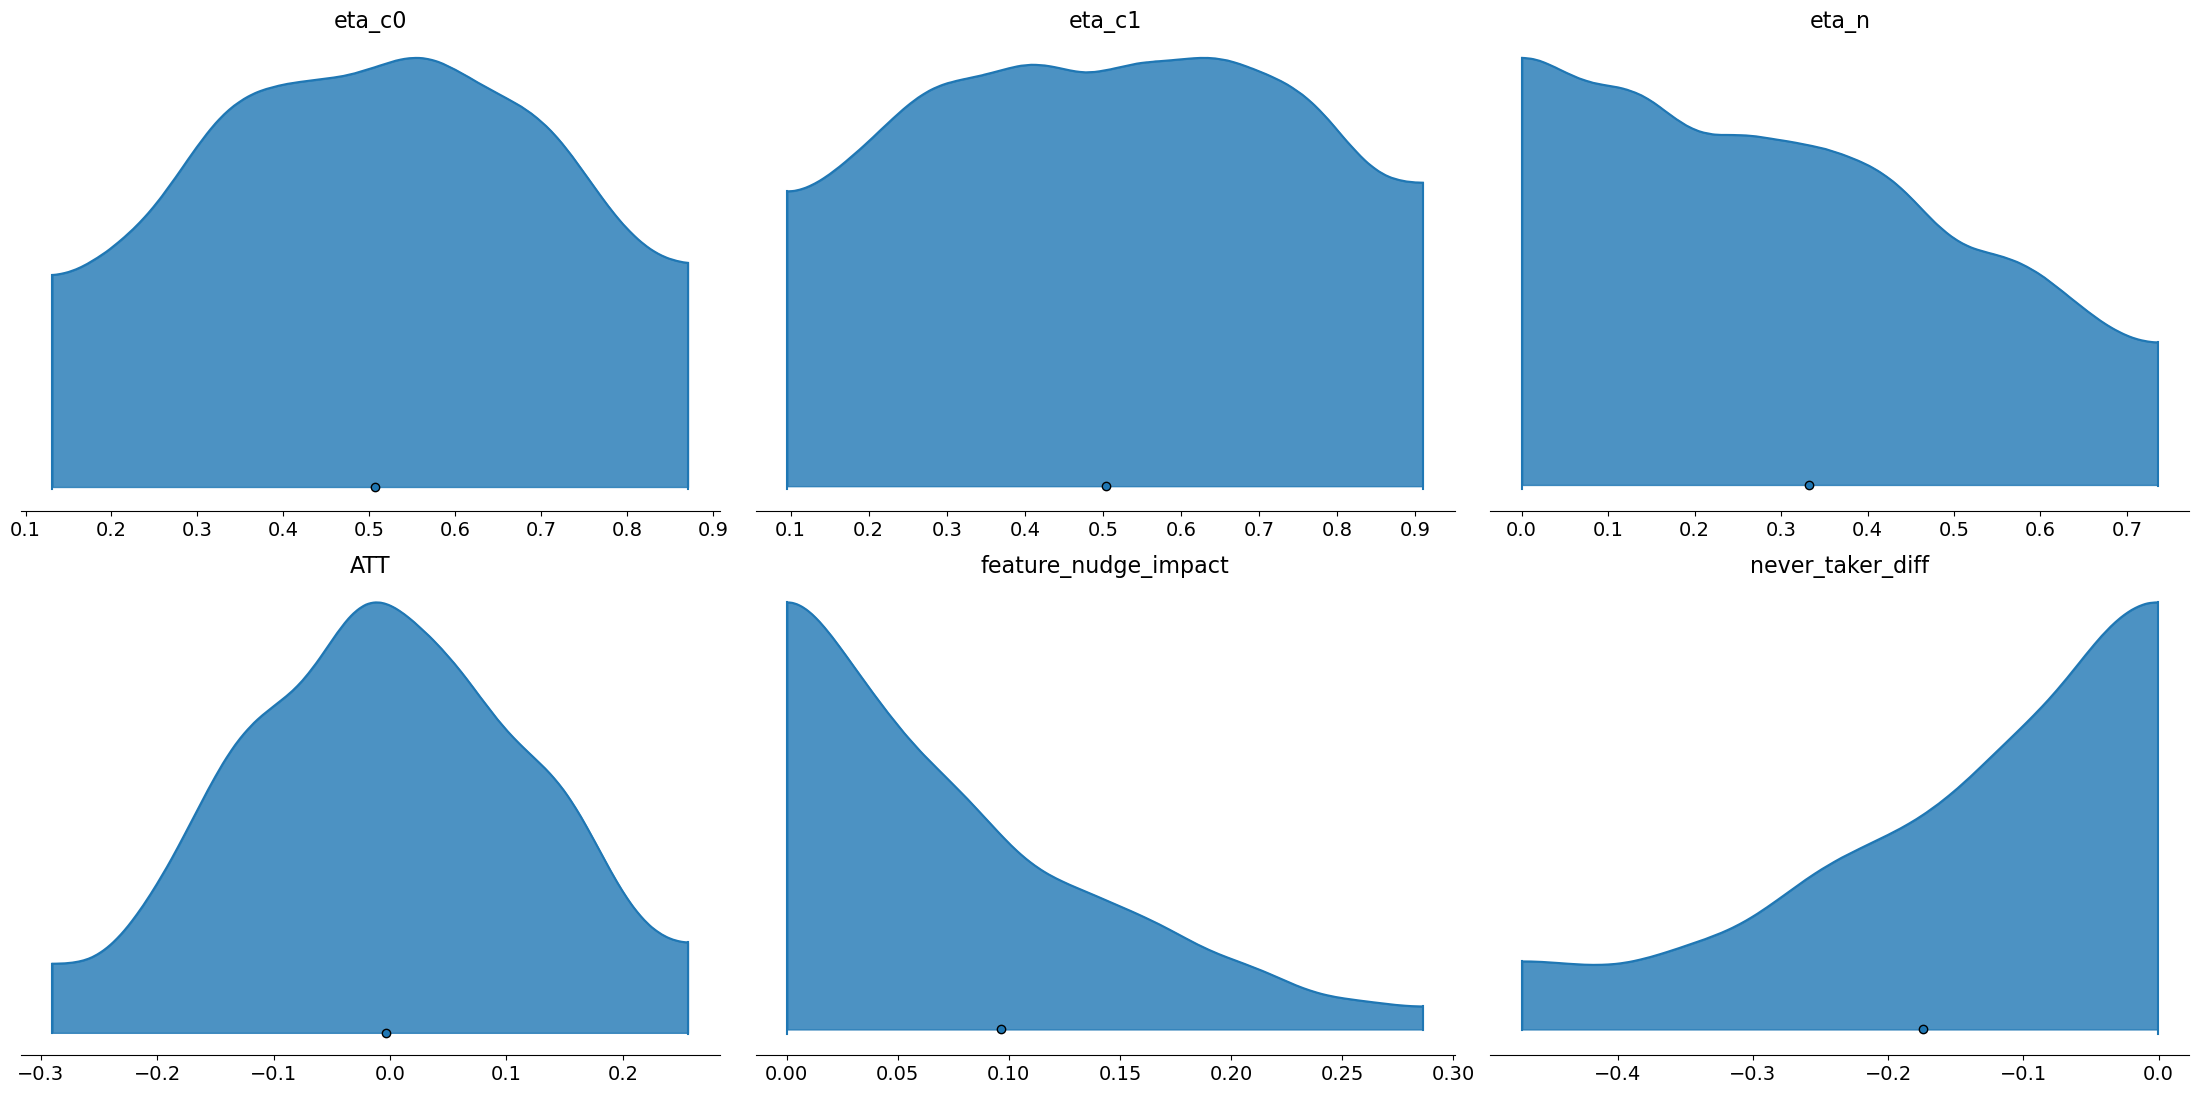

In [ ]:
az.plot_density(
    encouragement_trace,
    group="prior",
    var_names=["eta_c0", "eta_c1", "eta_n", "ATT", "feature_nudge_impact", "never_taker_diff"],
    hdi_prob=0.95,
    shade=0.8,
    grid=(2, 3),
)
plt.tight_layout()

In [ ]:
with encouragement_design:
    encouragement_trace.extend(
        pm.sample(draws=2_000, tune=1_000, chains=4, nuts_sampler="nutpie")
    )

/home/aurimas/micromamba/envs/pymc/lib/python3.12/site-packages/pymc/pytensorf.py:952: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
/home/aurimas/micromamba/envs/pymc/lib/python3.12/site-packages/pymc/pytensorf.py:952: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(


Progress,Draws,Divergences,Step Size,Gradients/Draw
,3000,0,0.54,3
,3000,0,0.59,15
,3000,0,0.55,15
,3000,0,0.59,7


In [ ]:
az.summary(
    encouragement_trace,
    var_names=[
        "pi_c",        
        "ATT",
        "feature_nudge_impact",
        "never_taker_diff",
    ],
    hdi_prob=0.95,
    round_to=4,
)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pi_c,0.2009,0.0018,0.1974,0.2045,0.0000,0.0000,4423.4295,5028.4597,1.0007
ATT,-0.0400,0.0061,-0.0520,-0.0283,0.0001,0.0001,3028.5838,4514.3000,1.0006
feature_nudge_impact,0.0789,0.0027,0.0736,0.0841,0.0000,0.0000,4987.6741,4992.9002,1.0004
never_taker_diff,-0.2915,0.0050,-0.3012,-0.2818,0.0001,0.0001,2331.7501,3392.0629,1.0010
